# MNIST with ipcmagic and TensorFlow-2.3

In [1]:
import ipcmagic
import ipyparallel as ipp

%ipcluster start -n 2 --mpi

rc = ipp.Client()
rc.ids

IPCluster is ready! (7 seconds)


[0, 1]

In [2]:
%%px
import os
import math
import json
import numpy as np

import tensorflow as tf
tf.__version__

Out[0:1]: '2.2.0'

Out[1:1]: '2.2.0'

In [3]:
%%px
import socket
socket.gethostname(), tf.config.list_physical_devices('GPU')

Out[0:2]: 
('nid06663',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

Out[1:2]: 
('nid06664',
 [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')])

In [4]:
%%px
# generally MultiWorkerMirroredStrategy requires 'TF_CONFIG' to be set, but in our case
# SlurmClusterResolver takes care of all the configuration
strategy = tf.distribute.experimental.MultiWorkerMirroredStrategy(
    cluster_resolver=tf.distribute.cluster_resolver.SlurmClusterResolver(),
    communication=tf.distribute.experimental.CollectiveCommunication.NCCL,
)

# os.environ['TF_CONFIG'] = json.dumps({
#     'cluster': {
#         'worker': [f"{os.environ['SLURM_JOB_NODELIST'][:4]}{node}:8888"
#                    for node in os.environ['SLURM_JOB_NODELIST'][5:-1].split('-')]
#     },
#     'task': {'type': 'worker', 'index': os.environ['SLURM_NODEID']}
# })
# os.environ['TF_CONFIG']

In [5]:
%%px
num_workers = int(os.environ['SLURM_NNODES'])
node_id = int(os.environ['SLURM_NODEID'])

per_worker_batch_size = 300
# Here the batch size scales up by number of workers since 
# `tf.data.Dataset.batch` expects the global batch size.
batch_size = per_worker_batch_size * num_workers

learning_rate = 1e-4 * batch_size

node_id, per_worker_batch_size, learning_rate

Out[0:4]: (0, 300, 0.060000000000000005)

Out[1:4]: (1, 300, 0.060000000000000005)

In [6]:
%%px
def build_and_compile_cnn_model(learning_rate=learning_rate):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=(28, 28)),
        tf.keras.layers.Reshape(target_shape=(28, 28, 1)), # Convolutional layers expect a channel dimension

        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(name='bn0'),

        tf.keras.layers.Conv2D(128, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(pool_size=(2, 2)),
        tf.keras.layers.BatchNormalization(name='bn1'),

        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(10),
    ])
    
    model.compile(
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.keras.optimizers.SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True),
        metrics=['accuracy'])

    model.summary()
    return model


with strategy.scope():
    # Model building/compiling need to be within `strategy.scope()`.
    multi_worker_model = build_and_compile_cnn_model()

[stdout:0] 
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 28, 28, 1)         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 28, 28, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 14, 14, 32)        0         
_________________________________________________________________
bn0 (BatchNormalization)     (None, 14, 14, 32)        128       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 14, 14, 128)       36992     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 7, 7, 128)         0         
_________________________________________________________________
bn1 (BatchNormalization)     (None, 7, 7, 12

In [7]:
%%px
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

train_size = len(y_train)
valid_size = len(y_test)

# The `x` arrays are in uint8 and have values in the range [0, 255].
# We need to convert them to float32 with values in the range [0, 1]
train_dataset = (tf.data.Dataset
                   .from_tensor_slices((x_train / np.float32(255), y_train.astype(np.int32)))
                   .shuffle(train_size)
                   .repeat()
                   .batch(batch_size, drop_remainder=True))

valid_dataset = (tf.data.Dataset
                   .from_tensor_slices((x_test / np.float32(255), y_test.astype(np.int32)))
                   .batch(batch_size, drop_remainder=False))

# In multi-worker training with MultiWorkerMirroredStrategy, sharding the dataset
# is needed to ensure convergence and performance. However, note that in code here,
# the datasets are directly passed to model.fit() without needing to shard; this is
# because tf.distribute.Strategy API takes care of the dataset sharding automatically.

train_size, valid_size

Out[0:6]: (60000, 10000)

Out[1:6]: (60000, 10000)

[output:0]

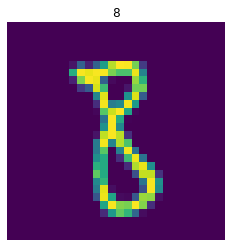

[output:1]

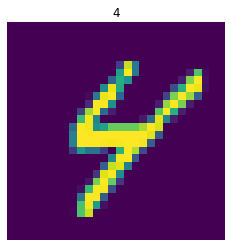

In [8]:
%%px
# show first training image on each node
for images, labels in train_dataset.take(1):
    from matplotlib import pyplot as plt
    plt.imshow(images[0])
    plt.axis('off')
    plt.title(str(labels[0].numpy()))

In [9]:
%%px
# Keras' `model.fit()` trains the model with specified number of steps and epochs across all nodes
steps_per_epoch = train_size // batch_size
validation_steps = math.ceil(valid_size / batch_size)
print(f'Training for {steps_per_epoch} steps per epoch across {num_workers} nodes')

[stdout:0] Training for 100 steps per epoch across 2 nodes
[stdout:1] Training for 100 steps per epoch across 2 nodes


In [10]:
%%px

multi_worker_model.fit(train_dataset,
                       epochs=7,
                       steps_per_epoch=steps_per_epoch,
                       validation_data=valid_dataset,
                       validation_steps=validation_steps,
                      )

[stdout:0] 
Epoch 1/7
100/100 [==============================] - 2s 22ms/step - accuracy: 0.8429 - loss: 4.2645 - val_accuracy: 0.7705 - val_loss: 1.8419
Epoch 2/7
100/100 [==============================] - 1s 9ms/step - accuracy: 0.9652 - loss: 0.1204 - val_accuracy: 0.9417 - val_loss: 0.2198
Epoch 3/7
100/100 [==============================] - 1s 9ms/step - accuracy: 0.9731 - loss: 0.0907 - val_accuracy: 0.9677 - val_loss: 0.1072
Epoch 4/7
100/100 [==============================] - 1s 9ms/step - accuracy: 0.9742 - loss: 0.0936 - val_accuracy: 0.9773 - val_loss: 0.0740
Epoch 5/7
100/100 [==============================] - 1s 9ms/step - accuracy: 0.9797 - loss: 0.0680 - val_accuracy: 0.9806 - val_loss: 0.0625
Epoch 6/7
100/100 [==============================] - 1s 9ms/step - accuracy: 0.9815 - loss: 0.0599 - val_accuracy: 0.9824 - val_loss: 0.0548
Epoch 7/7
100/100 [==============================] - 1s 9ms/step - accuracy: 0.9841 - loss: 0.0524 - val_accuracy: 0.9800 - val_loss: 0.0630


In [11]:
%%px
multi_worker_model.evaluate(valid_dataset, batch_size=batch_size, steps=validation_steps)

17/17 [==============================] - 0s 3ms/step - loss: 0.0630 - accuracy: 0.9800


In [12]:
%ipcluster stop

#### 